In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import plotly.express as px
%matplotlib inline


from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import StandardScaler
# from cuml.preprocessing import StandardScaler


sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

# import cudf # insted of pandas so it use gpu

# loading Data

In [2]:
data= pd.read_csv('/kaggle/input/shaon609/tondataset.csv')
data

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack
0,192.168.1.193,49235,192.168.1.33,4444,6,0.000,155392,202,34552,149,...,45555,4805,0,0,0,0,0,0,1,ransomware
1,192.168.1.193,49228,192.168.1.152,1880,6,0.000,1600,40,35741,65,...,16425,237,0,0,0,0,0,0,0,Benign
2,192.168.1.152,0,192.168.1.193,0,1,0.000,212,2,0,0,...,0,0,771,3,0,0,0,0,0,Benign
3,192.168.1.169,65317,239.255.255.250,1900,17,0.000,165,1,0,0,...,0,0,0,0,0,0,0,0,0,Benign
4,192.168.1.79,60766,192.168.1.255,15600,17,0.000,63,1,0,0,...,0,0,0,0,0,0,0,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16940491,192.168.1.152,1880,192.168.1.193,49178,6,0.000,31067,49,1160,29,...,237,16425,0,0,0,0,0,0,0,Benign
16940492,184.25.57.139,43,192.168.1.180,37796,6,170.000,4275,5,296,5,...,453,1024,19200,75,0,0,0,0,0,Benign
16940493,52.89.38.17,443,192.168.1.193,49198,6,91.178,191,4,151,3,...,64240,63846,0,0,0,0,0,0,0,Benign
16940494,192.168.1.190,53,192.168.1.193,57992,17,5.000,72,1,0,0,...,0,0,0,0,21860,12,0,0,0,Benign


# For Beaic Info

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16940496 entries, 0 to 16940495
Data columns (total 45 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   IPV4_SRC_ADDR                object 
 1   L4_SRC_PORT                  int64  
 2   IPV4_DST_ADDR                object 
 3   L4_DST_PORT                  int64  
 4   PROTOCOL                     int64  
 5   L7_PROTO                     float64
 6   IN_BYTES                     int64  
 7   IN_PKTS                      int64  
 8   OUT_BYTES                    int64  
 9   OUT_PKTS                     int64  
 10  TCP_FLAGS                    int64  
 11  CLIENT_TCP_FLAGS             int64  
 12  SERVER_TCP_FLAGS             int64  
 13  FLOW_DURATION_MILLISECONDS   int64  
 14  DURATION_IN                  int64  
 15  DURATION_OUT                 int64  
 16  MIN_TTL                      int64  
 17  MAX_TTL                      int64  
 18  LONGEST_FLOW_PKT             int64  
 19

In [5]:
data.isnull().sum()

IPV4_SRC_ADDR                  0
L4_SRC_PORT                    0
IPV4_DST_ADDR                  0
L4_DST_PORT                    0
PROTOCOL                       0
L7_PROTO                       0
IN_BYTES                       0
IN_PKTS                        0
OUT_BYTES                      0
OUT_PKTS                       0
TCP_FLAGS                      0
CLIENT_TCP_FLAGS               0
SERVER_TCP_FLAGS               0
FLOW_DURATION_MILLISECONDS     0
DURATION_IN                    0
DURATION_OUT                   0
MIN_TTL                        0
MAX_TTL                        0
LONGEST_FLOW_PKT               0
SHORTEST_FLOW_PKT              0
MIN_IP_PKT_LEN                 0
MAX_IP_PKT_LEN                 0
SRC_TO_DST_SECOND_BYTES        0
DST_TO_SRC_SECOND_BYTES        0
RETRANSMITTED_IN_BYTES         0
RETRANSMITTED_IN_PKTS          0
RETRANSMITTED_OUT_BYTES        0
RETRANSMITTED_OUT_PKTS         0
SRC_TO_DST_AVG_THROUGHPUT      0
DST_TO_SRC_AVG_THROUGHPUT      0
NUM_PKTS_U

In [6]:
unique_values= {}
for i in data.columns:
    unique_values[i]= data[i].nunique()
    
pd.DataFrame(unique_values,index= ['unique_value']).T

,unique_value
IPV4_SRC_ADDR,23079
L4_SRC_PORT,65536
IPV4_DST_ADDR,6868
L4_DST_PORT,65536
PROTOCOL,6
L7_PROTO,213
IN_BYTES,17363
IN_PKTS,2555
OUT_BYTES,15753
OUT_PKTS,1872


In [7]:
round(data.describe().T)

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,std,min,25%,50%,75%,max
L4_SRC_PORT,16940496.0,4.335400e+04,15173.0,0.0,37324.0,45770.0,54218.0,6.553500e+04
L4_DST_PORT,16940496.0,9.282000e+03,16853.0,0.0,80.0,443.0,8080.0,6.553500e+04
PROTOCOL,16940496.0,8.000000e+00,4.0,1.0,6.0,6.0,6.0,5.800000e+01
L7_PROTO,16940496.0,1.400000e+01,32.0,0.0,0.0,0.0,7.0,2.480000e+02
IN_BYTES,16940496.0,7.260000e+02,143318.0,4.0,44.0,52.0,276.0,3.019262e+08
IN_PKTS,16940496.0,6.000000e+00,509.0,1.0,1.0,1.0,4.0,4.692810e+05
OUT_BYTES,16940496.0,8.370000e+02,101785.0,0.0,0.0,40.0,180.0,1.644688e+08
OUT_PKTS,16940496.0,3.000000e+00,258.0,0.0,0.0,1.0,3.0,4.109030e+05
TCP_FLAGS,16940496.0,1.300000e+01,11.0,0.0,2.0,17.0,22.0,2.230000e+02
CLIENT_TCP_FLAGS,16940496.0,9.000000e+00,11.0,0.0,2.0,2.0,18.0,2.230000e+02


# Removing object type and convert object to Numeric Data

In [8]:
print(data['IPV4_SRC_ADDR'].nunique())  
print(data['IPV4_SRC_ADDR'].value_counts()) 

23079
IPV4_SRC_ADDR
192.168.1.31      4308656
192.168.1.32      3614669
192.168.1.30      3462837
192.168.1.35      1254234
192.168.1.39       983745
                   ...   
27.150.244.184          1
163.172.235.3           1
97.86.192.166           1
248.42.224.200          1
184.25.57.139           1
Name: count, Length: 23079, dtype: int64


In [9]:
ip_counts = data['IPV4_SRC_ADDR'].value_counts()
print(ip_counts.head(10))

IPV4_SRC_ADDR
192.168.1.31     4308656
192.168.1.32     3614669
192.168.1.30     3462837
192.168.1.35     1254234
192.168.1.39      983745
192.168.1.34      778418
192.168.1.38      447610
192.168.1.36      427523
192.168.1.184     345372
192.168.1.33      309253
Name: count, dtype: int64


In [3]:
import ipaddress

data['IPV4_SRC_ADDR_INT'] = data['IPV4_SRC_ADDR'].apply(lambda ip: int(ipaddress.ip_address(ip)))
data['IIPV4_DST_ADDR_INT'] = data['IPV4_DST_ADDR'].apply(lambda ip: int(ipaddress.ip_address(ip)))

In [4]:
print(data['Attack'].value_counts()) 

attack_mapping = {
    'Benign': 0,
    'scanning': 1,
    'xss': 2,
    'ddos': 3,
    'password': 4,
    'dos': 5,
    'injection': 6,
    'backdoor': 7,
    'mitm': 8,
    'ransomware': 9
}

data['Attack_Num'] = data['Attack'].map(attack_mapping)
#print(data[['Attack', 'Attack_Num']].head())

Attack
Benign        6099469
scanning      3781419
xss           2455020
ddos          2026234
password      1153323
dos            712609
injection      684465
backdoor        16809
mitm             7723
ransomware       3425
Name: count, dtype: int64


In [5]:
data = data.drop(columns=['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Label', 'Attack'])
data

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,IPV4_SRC_ADDR_INT,IIPV4_DST_ADDR_INT,Attack_Num
0,49235,4444,6,0.000,155392,202,34552,149,24,24,...,4805,0,0,0,0,0,0,3232235969,3232235809,9
1,49228,1880,6,0.000,1600,40,35741,65,24,16,...,237,0,0,0,0,0,0,3232235969,3232235928,0
2,0,0,1,0.000,212,2,0,0,0,0,...,0,771,3,0,0,0,0,3232235928,3232235969,0
3,65317,1900,17,0.000,165,1,0,0,0,0,...,0,0,0,0,0,0,0,3232235945,4026531834,0
4,60766,15600,17,0.000,63,1,0,0,0,0,...,0,0,0,0,0,0,0,3232235855,3232236031,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16940491,1880,49178,6,0.000,31067,49,1160,29,24,24,...,16425,0,0,0,0,0,0,3232235928,3232235969,0
16940492,43,37796,6,170.000,4275,5,296,5,25,25,...,1024,19200,75,0,0,0,0,3088660875,3232235956,0
16940493,443,49198,6,91.178,191,4,151,3,25,25,...,63846,0,0,0,0,0,0,878257681,3232235969,0
16940494,53,57992,17,5.000,72,1,0,0,0,0,...,0,0,0,21860,12,0,0,3232235966,3232235969,0


In [6]:
data.to_csv("for_lightGBM.csv", index=False)

# LightGBM

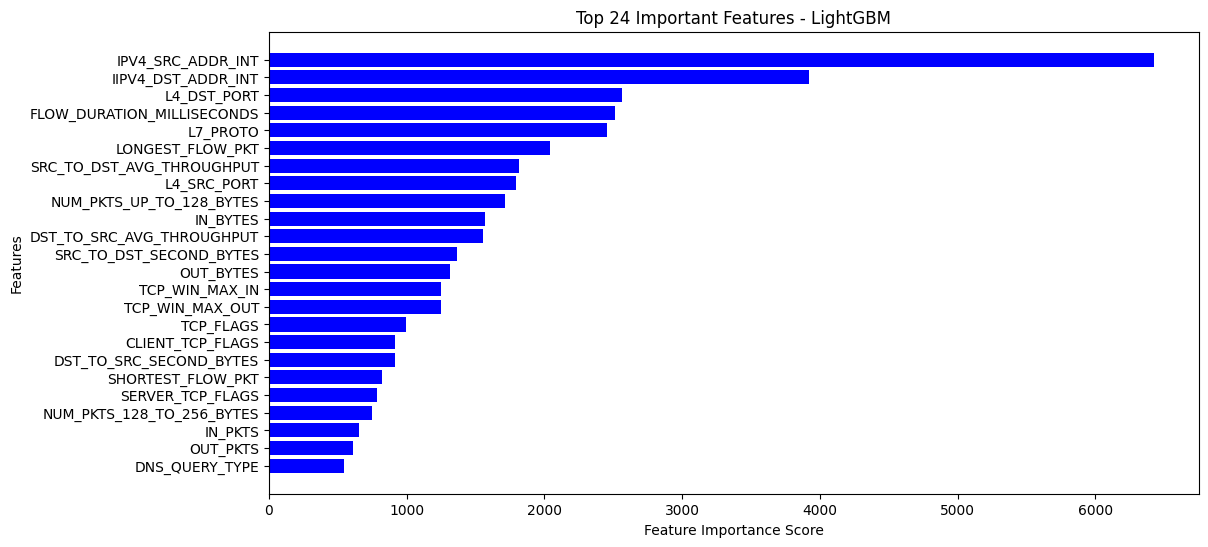

Selected 24 important features saved to 'X_selected_lightGBM.csv'


In [1]:
import pandas as pd
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def reduce_memory_usage(df):
    """Reduce memory usage by downcasting numeric columns."""
    for col in df.columns:
        col_type = df[col].dtype
        if col_type == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')  # Convert int64 to int32/uint16
        elif col_type == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')  # Convert float64 to float32
    return df

data = pd.read_csv('/kaggle/input/forfbm/for_lightGBM.csv')
data = reduce_memory_usage(data)

X = data.drop(columns=['Attack_Num'])
y = data['Attack_Num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

lgb_model = lgb.LGBMClassifier(
    n_estimators=150, 
    learning_rate=0.02, 
    num_leaves=31, 
    max_depth=-10, 
    random_state=42, 
    verbose=-1
)
lgb_model.fit(X_train, y_train)

feature_importance = lgb_model.feature_importances_
feature_names = np.array(X.columns) 

sorted_idx = np.argsort(feature_importance)[::-1]  

plt.figure(figsize=(12, 6))
plt.barh(feature_names[sorted_idx[:24]], feature_importance[sorted_idx[:24]], color='blue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 24 Important Features - LightGBM")
plt.gca().invert_yaxis()
plt.show()

N = 24
selected_features = feature_names[sorted_idx[:N]]

X_selected = X[selected_features]
X_selected.to_csv("X_selected_lightGBM.csv", index=False)
print(f"Selected {N} important features saved to 'X_selected_lightGBM.csv'")

In [ ]:
import pandas as pd
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

data= pd.read_csv('/kaggle/input/forfbm/for_lightGBM.csv')

X = data.drop(columns=['Attack_Num']) 
y = data['Attack_Num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

lgb_model = lgb.LGBMClassifier(n_estimators=150, random_state=42)
lgb_model.fit(X_train, y_train)

feature_importance = lgb_model.feature_importances_
feature_names = X.columns

sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(12, 6))
plt.barh([feature_names[i] for i in sorted_idx[:24]], feature_importance[sorted_idx[:24]], color='blue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 24 Important Features - LightGBM")
plt.gca().invert_yaxis()
plt.show()

N = 24
selected_features = [feature_names[i] for i in sorted_idx[:N]]

X_selected = X[selected_features]

X_selected.to_csv("X_selected_lightGBM.csv", index=False)

[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=10) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1024) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=10) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1024) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Number of positive: 6937952, number of negative: 3903964
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.346698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6365
[LightGBM] [Info] Number of data points in the train set:

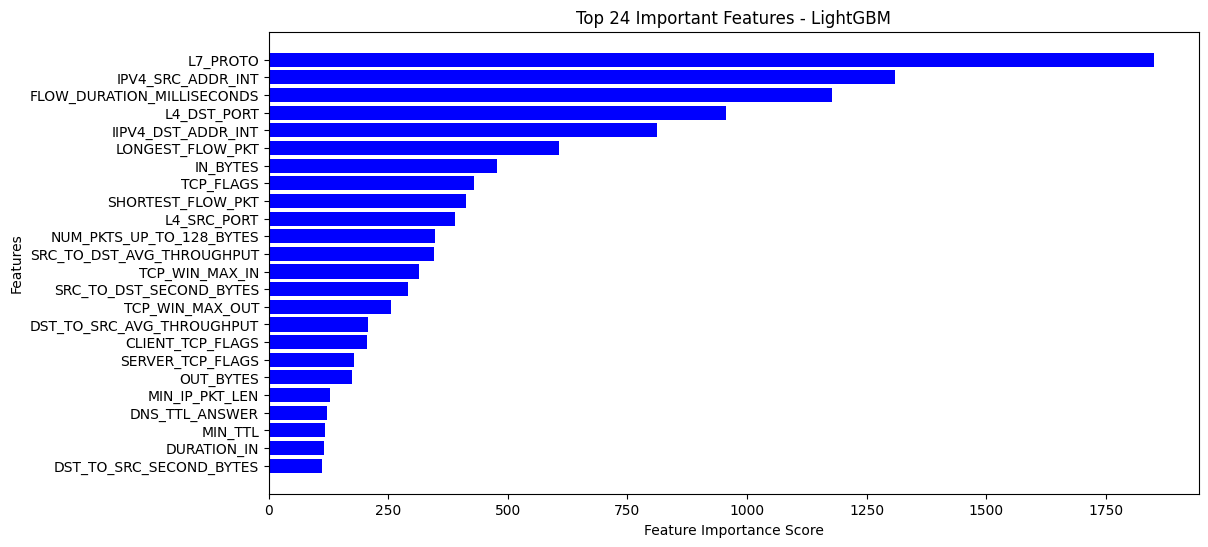

Selected 24 important features saved to 'X_selected_lightGBM.csv'


In [1]:
import pandas as pd
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

data = pd.read_csv('/kaggle/input/forfbm/for_lightGBM.csv')

X = data.drop(columns=['Attack_Num']) 
y = data['Attack_Num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

params = {
    'objective': 'binary', 
    'metric': 'auc',  
    'max_depth': 10,  
    'min_gain_to_split': 0.01,  
    'min_data_in_leaf': 15,  
    'is_unbalance': True,  
    'learning_rate': 0.05, 
}
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=["train", "valid"],  
    num_boost_round=400, 
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

feature_importance = model.feature_importance()
feature_names = np.array(X.columns)
sorted_idx = np.argsort(feature_importance)[::-1]

N = 24
plt.figure(figsize=(12, 6))
plt.barh(feature_names[sorted_idx[:N]][::-1], feature_importance[sorted_idx[:N]][::-1], color='blue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 24 Important Features - LightGBM")
plt.show()

selected_features = feature_names[sorted_idx[:N]]
X_selected = X[selected_features]

X_selected.to_csv("X_selected_lightGBM.csv", index=False)
print(f"Selected {N} important features saved to 'X_selected_lightGBM.csv'")

# Finding Co-relation

Pearson Correlation: Measures linear relationships between variables. 

Spearman Correlation: Measures monotonic relationships. 

Kendall Correlation: Measures ordinal association. 

VIF: Identifies multicollinearity among the features. 

Mutual Information: Measures the amount of information shared between features.

Random Forest Feature Importance: Evaluates the importance of each feature in predicting the target. 

# co relation Results --> > [link](https://docs.google.com/spreadsheets/d/1l1xjD19rsEPUwMST0mgDNdYR9Cp9jgXaOgYl4K7GShw/edit?gid=0#gid=0)

In [13]:
# data.corr()['Attack_Num'].sort_values(ascending= False)

In [14]:
# spearman_corr = data.corr(method='spearman')['Attack_Num'].sort_values(ascending= False)
# print("\nSpearman Correlation:\n", spearman_corr)

In [15]:
# kendall_corr = data.corr(method='kendall')['Attack_Num'].sort_values(ascending= False)
# print("\nKendall Correlation:\n", kendall_corr)

In [16]:
# X = data.select_dtypes(include=[np.number]).drop(columns=['Attack_Num'])

In [17]:
# vif_values = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
# vif_df = pd.DataFrame({'Feature': X.columns, 'VIF': vif_values})
# print("\nVIF (Variance Inflation Factor):\n", vif_df)

In [18]:
# mi_scores = mutual_info_regression(X, y)
# mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
# print("\nMutual Information:\n", mi_df)

In [19]:
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X, y)
# rf_importances = pd.DataFrame({'Feature': X.columns, 'RF Importance': rf.feature_importances_})
# print("\nFeature Importance (Random Forest):\n", rf_importances)

In [20]:
# pearson_corr = data.corr(method='pearson')['Attack_Num'].sort_values(ascending= False)
# print("Pearson Correlation:\n", pearson_corr)

# Removing Less Importent column

In [21]:
print(data.columns)

Index(['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES',
       'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS', 'TCP_FLAGS', 'CLIENT_TCP_FLAGS',
       'SERVER_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'DURATION_IN',
       'DURATION_OUT', 'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT',
       'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN',
       'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES',
       'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS',
       'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
       'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES',
       'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES',
       'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT',
       'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE',
       'DNS_TTL_ANSWER', 'FTP_COMMAND_RET_CODE', 'IPV4_SRC_ADDR_INT',
       'IIPV4_DST_ADDR_INT', 'Attack_Num'],
      dtype='ob

In [22]:
data = data.drop(columns=['MIN_IP_PKT_LEN', 'MIN_TTL', 'MAX_TTL', 'TCP_WIN_MAX_IN', 'CLIENT_TCP_FLAGS',
    'MAX_IP_PKT_LEN', 'LONGEST_FLOW_PKT', 'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS',
    'PROTOCOL', 'DURATION_OUT', 'DNS_QUERY_ID', 'DST_TO_SRC_AVG_THROUGHPUT',
    'DURATION_IN', 'SRC_TO_DST_AVG_THROUGHPUT', 'SHORTEST_FLOW_PKT',
    'FTP_COMMAND_RET_CODE', 'L7_PROTO', 'ICMP_IPV4_TYPE', 'ICMP_TYPE'])
data

,L4_SRC_PORT,L4_DST_PORT,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,SERVER_TCP_FLAGS,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,...,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_OUT,DNS_QUERY_TYPE,DNS_TTL_ANSWER,IPV4_SRC_ADDR_INT,IIPV4_DST_ADDR_INT,Attack_Num
0,49235,4444,155392,202,34552,149,24,155392.0,34552.0,0,...,150,36,14,95,4805,0,0,3232235969,3232235809,9
1,49228,1880,1600,40,35741,65,24,1600.0,35741.0,0,...,3,30,19,6,237,0,0,3232235969,3232235928,0
2,0,0,212,2,0,0,0,212.0,0.0,0,...,0,0,0,0,0,0,0,3232235928,3232235969,0
3,65317,1900,165,1,0,0,0,165.0,0.0,0,...,1,0,0,0,0,0,0,3232235945,4026531834,0
4,60766,15600,63,1,0,0,0,63.0,0.0,0,...,0,0,0,0,0,0,0,3232235855,3232236031,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16940491,1880,49178,31067,49,1160,29,16,31067.0,1160.0,0,...,1,14,16,9,16425,0,0,3232235928,3232235969,0
16940492,43,37796,4275,5,296,5,17,4275.0,296.0,4171,...,0,0,0,3,1024,0,0,3088660875,3232235956,0
16940493,443,49198,191,4,151,3,25,191.0,151.0,0,...,0,0,0,0,63846,0,0,878257681,3232235969,0
16940494,53,57992,72,1,0,0,0,72.0,0.0,0,...,0,0,0,0,0,12,0,3232235966,3232235969,0


In [25]:
data.to_csv("cleaned_data.csv", index=False)

In [ ]:
round(data.describe().T)

In [ ]:
# data.isnull().sum()

# finding Outlaier

In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# numeric_cols = data.select_dtypes(include=['number'])
# sns.pairplot(numeric_cols, diag_kind="kde")  

# plt.show()

In [ ]:
df = data.copy()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)  # Drop rows with NaN values

numeric_cols = df.select_dtypes(include=['number']).columns
numeric_cols = numeric_cols.drop("Attack_Num", errors="ignore")  # Exclude target column

def remove_outliers(df, threshold=3):
    numeric_df = df[numeric_cols]
    z_scores = np.abs((numeric_df - numeric_df.mean()) / numeric_df.std())
    return df[(z_scores < threshold).all(axis=1)]  # Keep rows without outliers

df_cleaned = remove_outliers(df)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_cleaned[numeric_cols])

df_cleaned[numeric_cols] = scaled_features

data = df_cleaned.copy()

In [ ]:
data